Data: 21263 rows, 81 numeric features


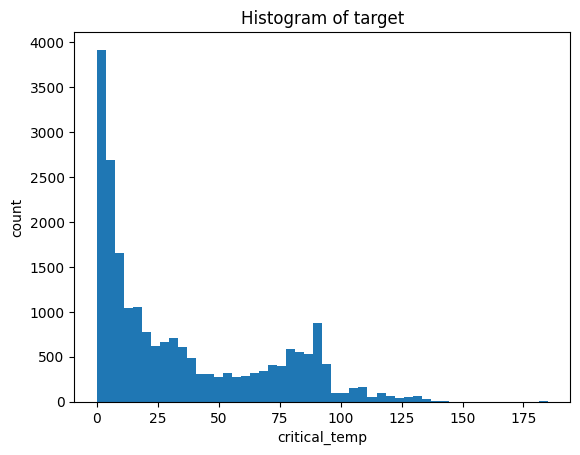


📊 Top 15 correlated features with target:
                        feature  corr_with_target
0   wtd_std_ThermalConductivity          0.721271
1     range_ThermalConductivity          0.687654
2           range_atomic_radius          0.653759
3       std_ThermalConductivity          0.653632
4              wtd_mean_Valence         -0.632401
5       wtd_entropy_atomic_mass          0.626930
6             wtd_gmean_Valence         -0.615653
7     wtd_entropy_atomic_radius          0.603494
8            number_of_elements          0.601069
9                     range_fie          0.600790
10                 mean_Valence         -0.600085
11        wtd_std_atomic_radius          0.599199
12              entropy_Valence          0.598591
13          wtd_entropy_Valence          0.589664
14                  wtd_std_fie          0.582013

📊 Cross-validation comparison (3-fold):
    model  cv_mean_RMSE  cv_std_RMSE
0      GB     11.989865     0.049616
1  Linear     17.698124     0.284961
2   R

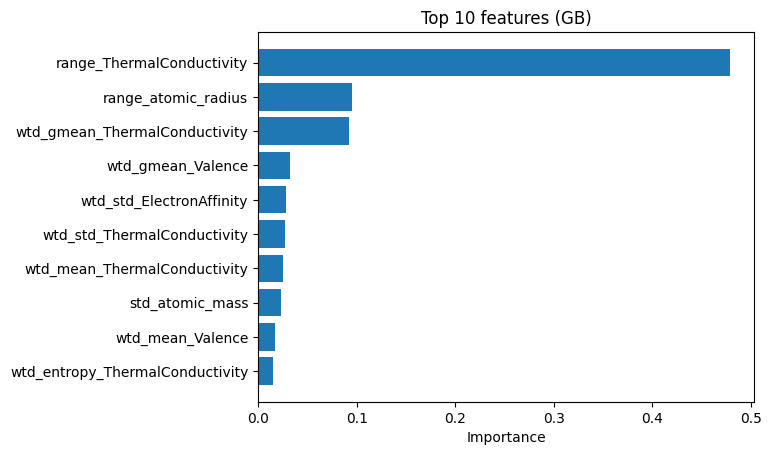

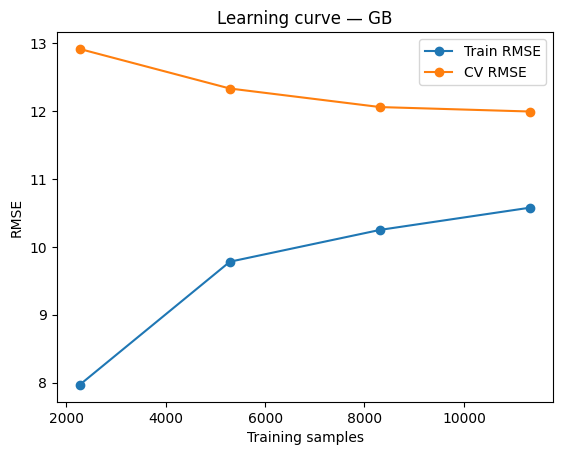

In [ ]:
import sys, math, zipfile, time
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ZIP_PATH = "/content/superconductivty+data.zip"
TARGET   = "critical_temp"
RANDOM_STATE = 42
OUTDIR   = Path("/content/sta5703_submit")
(OUTDIR / "figures").mkdir(parents=True, exist_ok=True)
(OUTDIR / "results").mkdir(parents=True, exist_ok=True)
(OUTDIR / "tables").mkdir(parents=True, exist_ok=True)

t0 = time.time()

extract_dir = OUTDIR / "data"
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(extract_dir)
train_path = next(extract_dir.rglob("train.csv"))
df = pd.read_csv(train_path)

y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET]).select_dtypes(include=[np.number])
print(f"Data: {df.shape[0]} rows, {X.shape[1]} numeric features")

# Histogram (figure)
fig = plt.figure()
plt.hist(y, bins=50)
plt.xlabel(TARGET); plt.ylabel("count"); plt.title("Histogram of target")
fig.savefig(OUTDIR / "figures" / "hist_target.png", bbox_inches="tight", dpi=150)
plt.show()

# Top-15 correlations (table)
corr = X.copy(); corr["__t__"] = y
corr_tbl = (
    corr.corr(numeric_only=True)["__t__"]
    .dropna().drop(labels="__t__", errors="ignore")
    .sort_values(key=lambda s: s.abs(), ascending=False)
    .head(15).reset_index()
    .rename(columns={"index":"feature","__t__":"corr_with_target"})
)
corr_tbl.to_csv(OUTDIR / "tables" / "top15_corr.csv", index=False)
print("\n📊 Top 15 correlated features with target:")
print(corr_tbl)

# Split & preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), X.columns)
])

# Models (small + fast)
models = {
    "Linear": Pipeline([("pre", pre), ("model", LinearRegression())]),
    "Ridge":  Pipeline([("pre", pre), ("model", RidgeCV(alphas=np.logspace(-3,3,7), cv=3))]),
    "GB":     Pipeline([("pre", pre), ("model", GradientBoostingRegressor(
                random_state=RANDOM_STATE, n_estimators=200, learning_rate=0.1, max_depth=3))])
}

# 3-fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
rows = []
for name, pipe in models.items():
    neg_mse = cross_val_score(pipe, X_train, y_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
    rmse = np.sqrt(-neg_mse)
    rows.append({"model": name, "cv_mean_RMSE": rmse.mean(), "cv_std_RMSE": rmse.std()})
comp = pd.DataFrame(rows).sort_values("cv_mean_RMSE").reset_index(drop=True)
comp.to_csv(OUTDIR / "results" / "model_comparison_cv.csv", index=False)
print("\n📊 Cross-validation comparison (3-fold):")
print(comp)

# Final hold-out with best CV model
best_name = comp.iloc[0]["model"]
best_pipe = models[best_name].fit(X_train, y_train)
pred = best_pipe.predict(X_test)
final = pd.DataFrame([{
    "model": best_name,
    "test_RMSE": math.sqrt(mean_squared_error(y_test, pred)),
    "test_MAE":  mean_absolute_error(y_test, pred),
    "test_R2":   r2_score(y_test, pred)
}])
final.to_csv(OUTDIR / "results" / "final_holdout_metrics.csv", index=False)
print("\n🏁 Final hold-out evaluation:")
print(final)

# Feature importance (if GB wins)
model = best_pipe.named_steps["model"]
if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({"feature": X.columns, "importance": model.feature_importances_})
    fi = fi.sort_values("importance", ascending=False).head(10)
    fi.to_csv(OUTDIR / "tables" / f"feature_importance_{best_name}.csv", index=False)
    print(f"\n🌟 Top 10 features ({best_name}):")
    print(fi)
    fig = plt.figure()
    plt.barh(fi["feature"], fi["importance"])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance"); plt.title(f"Top 10 features ({best_name})")
    fig.savefig(OUTDIR / "figures" / f"feature_importance_{best_name}.png", bbox_inches="tight", dpi=150)
    plt.show()

# learning curve for the best model
ts, train_scores, val_scores = learning_curve(
    best_pipe, X_train, y_train, cv=3, scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.2, 1.0, 4), n_jobs=-1, shuffle=True, random_state=RANDOM_STATE
)
train_rmse = np.sqrt(-train_scores).mean(axis=1)
val_rmse   = np.sqrt(-val_scores).mean(axis=1)

fig = plt.figure()
plt.plot(ts, train_rmse, marker="o", label="Train RMSE")
plt.plot(ts, val_rmse, marker="o", label="CV RMSE")
plt.xlabel("Training samples"); plt.ylabel("RMSE")
plt.title(f"Learning curve — {best_name}")
plt.legend()
fig.savefig(OUTDIR / "figures" / f"learning_curve_{best_name}.png", bbox_inches="tight", dpi=150)
plt.show()


